## 稀疏数据和嵌入简介
**学习目标**：
- 把影评字符串转换为稀疏特征矢量
- 使用稀疏特征矢量实现情感分析线性模型
- 通过将数据投射到二维空间的嵌入来实现情感分析
- 将嵌入可视化，以便查看模型学到的词语之间的关系

在此练习中，我们将探讨稀疏数据，并使用影评文本数据（来自 [ACL 2011 IMDB 数据集](http://ai.stanford.edu/~amaas/data/sentiment/)）进行嵌入。这些数据已被处理成 `tf.Example` 格式。

### 设置
导入依赖项并下载数据集，我们将使用```tf.keras```中的文件下载和缓存api

In [2]:
from __future__ import print_function

import collections
import io
import math

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://download.mlcc.google.cn/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://download.mlcc.google.cn/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)


/Users/kevin/.virtualenvs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/kevin/.virtualenvs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


40689664/40688441 [==============================] - 9s 0us/step


### 构建情况分析模型
我们根据这些训练数据训练一个情感分析模型，用以预测一条评论总体上是好评(标签为1)还是差评(标签为0)

为此，我们会使用词汇表（即我们预计将在数据中看到的每个术语的列表），将字符串值 terms 转换为特征矢量。在本练习中，我们创建了侧重于一组有限术语的小型词汇表。其中的大多数术语明确表示是好评或差评，但有些只是因为有趣而被添加进来。

词汇表中的每个术语都与特征矢量中的一个坐标相对应。为了将样本的字符串值 terms 转换为这种矢量格式，我们按以下方式处理字符串值：如果该术语没有出现在样本字符串中，则坐标值将为 0；如果出现在样本字符串中，则值为 1。未出现在该词汇表中的样本中的术语将被弃用。

> **注意**：我们当然可以使用更大的词汇表，而且有创建此类词汇表的专用工具。此外，我们可以添加少量的 OOV（未收录词汇）分桶，您可以在其中对词汇表中未包含的术语进行哈希处理，而不仅仅是弃用这些术语。我们还可以使用特征哈希法对每个术语进行哈希处理，而不是创建显式词汇表。这在实践中很有效，但却不具备可解读性（这对本练习非常实用）。如需了解处理此类词汇表的工具，请参阅 tf.feature_column 模块。

### 构建输入管线
配置输入管线，将数据导入TensorFlow模型中。

In [3]:
def _parse_function(record):
    """提取record的特征和标签
    Args:
        record: TFRecord文件的路径
    Returns:
        包含特征和标签的元组
    """
    features = {"terms": tf.VarLenFeature(dtype=tf.string), # 字符串是变长的
                "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # 0 或 1
               }
    parsed_features = tf.parse_single_example(record, features)
    
    terms = parsed_features['terms'].values
    labels = parsed_features['labels']
    
    return {"terms": terms}, labels

In [4]:
# 验证函数
ds = tf.data.TFRecordDataset(train_path)
ds = ds.map(_parse_function)

ds

<MapDataset shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

In [5]:
# 从训练数据集得到一个样本
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array([b'but', b'it', b'does', b'have', b'some', b'good', b'action',
         b'and', b'a', b'plot', b'that', b'is', b'somewhat', b'interesting',
         b'.', b'nevsky', b'acts', b'like', b'a', b'body', b'builder',
         b'and', b'he', b'isn', b"'", b't', b'all', b'that', b'attractive',
         b',', b'in', b'fact', b',', b'imo', b',', b'he', b'is', b'ugly',
         b'.', b'(', b'his', b'acting', b'skills', b'lack', b'everything',
         b'!', b')', b'sascha', b'is', b'played', b'very', b'well', b'by',
         b'joanna', b'pacula', b',', b'but', b'she', b'needed', b'more',
         b'lines', b'than', b'she', b'was', b'given', b',', b'her',
         b'character', b'needed', b'to', b'be', b'developed', b'.',
         b'there', b'are', b'way', b'too', b'many', b'men', b'in', b'this',
         b'story', b',', b'there', b'is', b'zero', b'romance', b',', b'too',
         b'much', b'action', b',', b'and', b'way', b'too', b'dumb', b'of',
         b'an', b'ending', b'.', b'

**构建正式的输入函数**

In [6]:
# 输入函数把传入的tf.Examples转到特征和标签
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function)
    if shuffle:
        ds = ds.shuffle(10000)
        
    # 分批，由于我们的特征数据是变长的，我们需要填充到我们需要的大小
    ds = ds.padded_batch(25, ds.output_shapes)
    ds = ds.repeat(num_epochs)
    
    # 返回下一个批的数据
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

### 任务1. 使用具有稀疏输入和显式词汇表的线性模型
对于我们的第一个模型，我们将使用 50 个信息性术语来构建 LinearClassifier 模型；始终从简单入手！

以下代码将为我们的术语构建特征列。categorical_column_with_vocabulary_list 函数可使用“字符串-特征矢量”映射来创建特征列。

In [8]:
# 由50个信息性术语组成的模型词表库
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms",
                                                                                 vocabulary_list=informative_terms)
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [terms_feature_column]

classifier = tf.estimator.LinearClassifier(feature_columns=feature_columns,
                                          optimizer=my_optimizer)

classifier.train(input_fn=lambda: _input_fn([train_path]),
                steps=1000)

evaluation_metrics = classifier.evaluate(input_fn=lambda: _input_fn([train_path]),
                                        steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(input_fn=lambda: _input_fn([test_path]),
                                        steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78856
accuracy_baseline 0.5
auc 0.8723401
auc_precision_recall 0.8642683
average_loss 0.45038867
label/mean 0.5
loss 11.259717
precision 0.7713254
prediction/mean 0.4932918
recall 0.82032
global_step 1000
---
Test set metrics:
accuracy 0.78508
accuracy_baseline 0.5
auc 0.87001806
auc_precision_recall 0.86176896
average_loss 0.4523892
label/mean 0.5
loss 11.309731
precision 0.76876086
prediction/mean 0.49225926
recall 0.81544
global_step 1000
---


### 任务2. 使用深度神经网络
上述模型是一个线性模型，效果很好，我们期望用DNN实现更好的效果。

In [9]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=[tf.feature_column.indicator_column(terms_feature_column)],
    hidden_units=[20,20],
    optimizer=my_optimizer)

try:
    classifier.train(
        input_fn=lambda: _input_fn([train_path]),
        steps=1000)

    evaluation_metrics = classifier.evaluate(
        input_fn=lambda: _input_fn([train_path]),
        steps=1)
    print("Training set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")

    evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1)

    print("Test set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
except ValueError as err:
    print(err)

Training set metrics:
accuracy 0.84
accuracy_baseline 0.56
auc 0.8896103
auc_precision_recall 0.9321141
average_loss 0.5072969
label/mean 0.56
loss 12.682424
precision 0.9166667
prediction/mean 0.5239192
recall 0.78571427
global_step 1000
---
Test set metrics:
accuracy 0.76
accuracy_baseline 0.6
auc 0.8866666
auc_precision_recall 0.9357188
average_loss 0.36529776
label/mean 0.6
loss 9.132444
precision 0.7647059
prediction/mean 0.6110293
recall 0.8666667
global_step 1000
---


### 任务3. 在DNN中使用嵌入
浅入列会将稀疏数据作为输入，并返回一个低维密集矢量作为输出。

从计算方面而言，embedding_column 通常是用于在稀疏数据中训练模型最有效的选项。

In [19]:
# 定义特征列
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[20,20],
    optimizer=my_optimizer)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

print("Training set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78436
accuracy_baseline 0.5
auc 0.867746
auc_precision_recall 0.85686666
average_loss 0.4552433
label/mean 0.5
loss 11.381082
precision 0.78811705
prediction/mean 0.4854057
recall 0.77784
global_step 1000
---
Test set metrics:
accuracy 0.77988
accuracy_baseline 0.5
auc 0.86646193
auc_precision_recall 0.85568726
average_loss 0.45715296
label/mean 0.5
loss 11.428824
precision 0.7870682
prediction/mean 0.48428935
recall 0.76736
global_step 1000
---


#### 确信模型中确实存在嵌入
上述模型使用了 embedding_column，而且似乎很有效，但这并没有让我们了解到内部发生的情形。我们如何检查该模型确实在内部使用了嵌入？

首先，我们来看看该模型中的张量：

In [11]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

In [12]:
# 注意：在我们的示例中，嵌入是一个矩阵，可让我们将一个 50 维矢量投射到 2 维空间。
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(50, 2)

#### 检查嵌入
现在，我们来看看实际嵌入空间，并了解术语(terms)最终所在的位置。请执行以下操作：
1. 运行以下代码来查看我们在**任务 3** 中训练的嵌入。一切最终是否如您所预期的那样？

2. 重新运行**任务 3** 中的代码来重新训练该模型，然后再次运行下面的嵌入可视化。哪些保持不变？哪些发生了变化？

3. 最后，仅使用 10 步来重新训练该模型（这将产生一个糟糕的模型）。再次运行下面的嵌入可视化。您现在看到了什么？为什么？

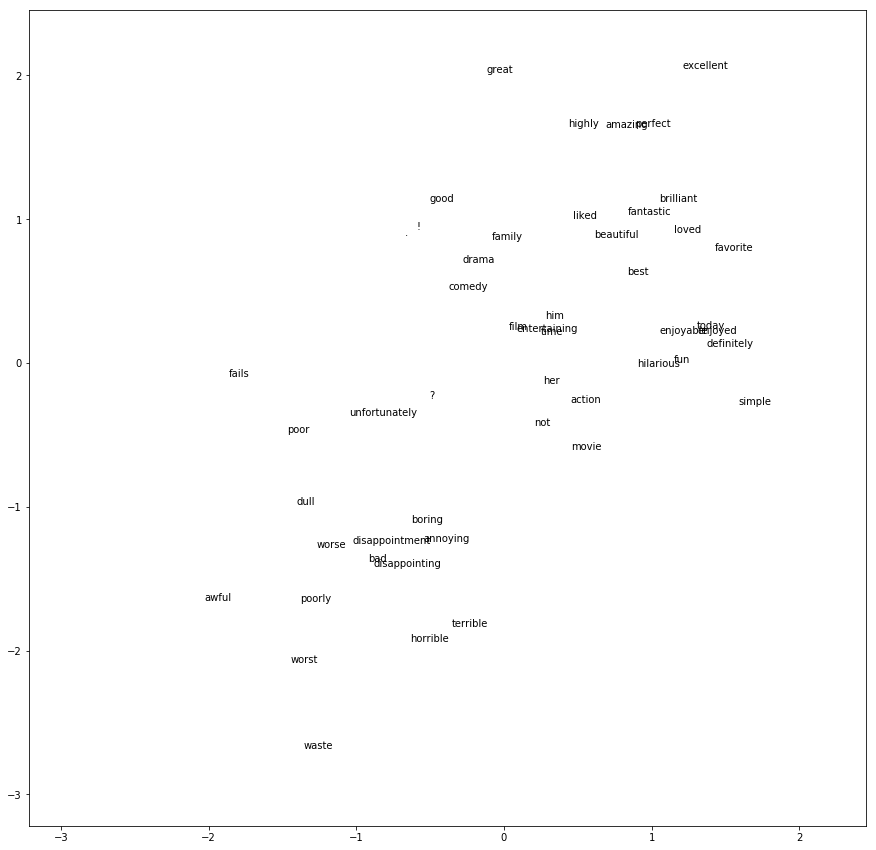

In [20]:
import numpy as np
from matplotlib import pyplot as plt

embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
    # 创建独热编码矢量
    term_vector = np.zeros(len(informative_terms))
    term_vector[term_index] = 1
    # 通过嵌入矩阵把稀疏的独热矢量投射到嵌入空间
    embedding_xy = np.matmul(term_vector, embedding_matrix)
    plt.text(embedding_xy[0],embedding_xy[1], informative_terms[term_index])

# 配置matplotlib
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show()     

### 任务4. 尝试改进模型的效果
我们可以尝试以下的做法：
- **更改超参数**或**使用别的优化工具**，如：Adam
- 向 informative_terms 添加其他术语
  > 此数据集有一个完整的词汇表文件，其中包含 30716 个术语，您可以在以下位置找到该文件：https://download.mlcc.google.cn/mledu-datasets/sparse-data-embedding/terms.txt 您可以从该词汇表文件中挑选出其他术语，也可以通过 categorical_column_with_vocabulary_file 特征列使用整个词汇表文件。 

In [23]:
# 下载词表库文件
terms_url = 'https://download.mlcc.google.cn/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

In [25]:
# 使用完整的信息词表库，创建完整的特征列
informative_terms = None
with io.open(terms_path, 'r', encoding='utf-8') as f:
    # 去掉重复的项，利用set集合的特性
    informative_terms = list(set(f.read().split()))

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(
    key="terms", vocabulary_list=informative_terms)
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [terms_embedding_column]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[20,20],
    optimizer=my_optimizer)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

print("Training set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.8378
accuracy_baseline 0.5
auc 0.91327506
auc_precision_recall 0.9104441
average_loss 0.37485465
label/mean 0.5
loss 9.3713665
precision 0.83989376
prediction/mean 0.49683505
recall 0.83472
global_step 1000
---
Test set metrics:
accuracy 0.82004
accuracy_baseline 0.5
auc 0.8986061
auc_precision_recall 0.8953606
average_loss 0.40410164
label/mean 0.5
loss 10.102541
precision 0.82447886
prediction/mean 0.49380606
recall 0.8132
global_step 1000
---


 ### 总结

我们可能获得了比我们原来的线性模型更好且具有嵌入的 DNN 解决方案，但线性模型也相当不错，而且训练速度快得多。线性模型的训练速度之所以更快，是因为它们没有太多要更新的参数或要反向传播的层。

在有些应用中，线性模型的速度可能非常关键，或者从质量的角度来看，线性模型可能完全够用。在其他领域，DNN 提供的额外模型复杂性和能力可能更重要。在定义模型架构时，请记得要充分探讨您的问题，以便知道自己所处的情形。

### *可选内容：*在 `embedding_column` 与 `indicator_column` 之间进行权衡
从概念上讲，在训练 `LinearClassifier` 或 `DNNClassifier` 时，需要根据实际情况使用稀疏列。TF 提供了两个选项：`embedding_column` 或 `indicator_column`。

在训练 LinearClassifier（如**任务 1** 中所示）时，系统在后台使用了 `embedding_column`。正如**任务 2** 中所示，在训练 `DNNClassifier` 时，您必须明确选择 `embedding_column` 或 `indicator_column`。本部分通过一个简单的示例讨论了这两者之间的区别，以及如何在二者之间进行权衡。

 假设我们的稀疏数据包含 `"great"`、`"beautiful"` 和 `"excellent"` 这几个值。由于我们在此处使用的词汇表大小为 $V = 50$，因此第一层中的每个单元（神经元）的权重将为 50。我们用 $s$ 表示稀疏输入中的项数。对于此示例稀疏数据，$s = 3$。对于具有 $V$ 个可能值的输入层，带有 $d$ 个单元的隐藏层需要运行一次“矢量 - 矩阵”乘法运算：$(1 \times V) * (V \times d)$。此运算会产生 $O(V * d)$ 的计算成本。请注意，此成本与隐藏层中的权重数成正比，而与 $s$ 无关。

如果输入使用 [`indicator_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column) 进行了独热编码（长度为 $V$ 的布尔型矢量，存在用 1 表示，其余则为 0），这表示很多零进行了相乘和相加运算。

 当我们通过使用大小为 $d$ 的 [`embedding_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) 获得完全相同的结果时，我们将仅查询与示例输入中存在的 3 个特征 `"great"`、`"beautiful"` 和 `"excellent"` 相对应的嵌入并将这三个嵌入相加：$(1 \times d) + (1 \times d) + (1 \times d)$。由于不存在的特征的权重在“矢量-矩阵”乘法中与 0 相乘，因此对结果没有任何影响；而存在的特征的权重在“矢量-矩阵”乘法中与 1 相乘。因此，将通过嵌入查询获得的权重相加会获得与“矢量-矩阵”乘法相同的结果。

当使用嵌入时，计算嵌入查询是一个 $O(s * d)$ 计算；从计算方面而言，它比稀疏数据中的 `indicator_column` 的 $O(V * d)$ 更具成本效益，因为 $s$ 远远小于 $V$。（请注意，这些嵌入是临时学习的结果。在任何指定的训练迭代中，都是当前查询的权重。

 正如我们在**任务 3** 中看到的，通过在训练 `DNNClassifier` 过程中使用 `embedding_column`，我们的模型学习了特征的低维度表示法，其中点积定义了一个针对目标任务的相似性指标。在本例中，影评中使用的相似术语（例如 `"great"` 和 `"excellent"`）在嵌入空间中彼此之间距离较近（即具有较大的点积），而相异的术语（例如 `"great"` 和 `"bad"`）在嵌入空间中彼此之间距离较远（即具有较小的点积）。